In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# 1. Data Preprocessing

In [7]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
sample_submission = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')

train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])


train = train[train['date'] >= '2016-01-01']
test = test[test['date'] >= '2016-01-01']

train['holiday'] = train['date'].isin(holidays['date'])
test['holiday'] = test['date'] == pd.to_datetime('2017-08-24')

train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['weekday'] = train['date'].dt.weekday

test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['weekday'] = test['date'].dt.weekday

train = train.drop(columns=['date'])
test = test.drop(columns=['date'])

object_cols = train.select_dtypes(include=['object']).columns
train = pd.get_dummies(train, columns=object_cols, drop_first=True)
test = pd.get_dummies(test, columns=object_cols, drop_first=True)

train, test = train.align(test, join='left', axis=1, fill_value=0)

print(train.head())
print(test.head())

/tmp/ipykernel_30/1439433117.py:21: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  train['holiday'] = train['date'].isin(holidays['date'])


              id  store_nbr  sales  onpromotion  holiday  year  month  day  \
1945944  1945944          1    0.0            0     True  2016      1    1   
1945945  1945945          1    0.0            0     True  2016      1    1   
1945946  1945946          1    0.0            0     True  2016      1    1   
1945947  1945947          1    0.0            0     True  2016      1    1   
1945948  1945948          1    0.0            0     True  2016      1    1   

         weekday  family_BABY CARE  ...  family_MAGAZINES  family_MEATS  \
1945944        4             False  ...             False         False   
1945945        4              True  ...             False         False   
1945946        4             False  ...             False         False   
1945947        4             False  ...             False         False   
1945948        4             False  ...             False         False   

         family_PERSONAL CARE  family_PET SUPPLIES  \
1945944                 Fa

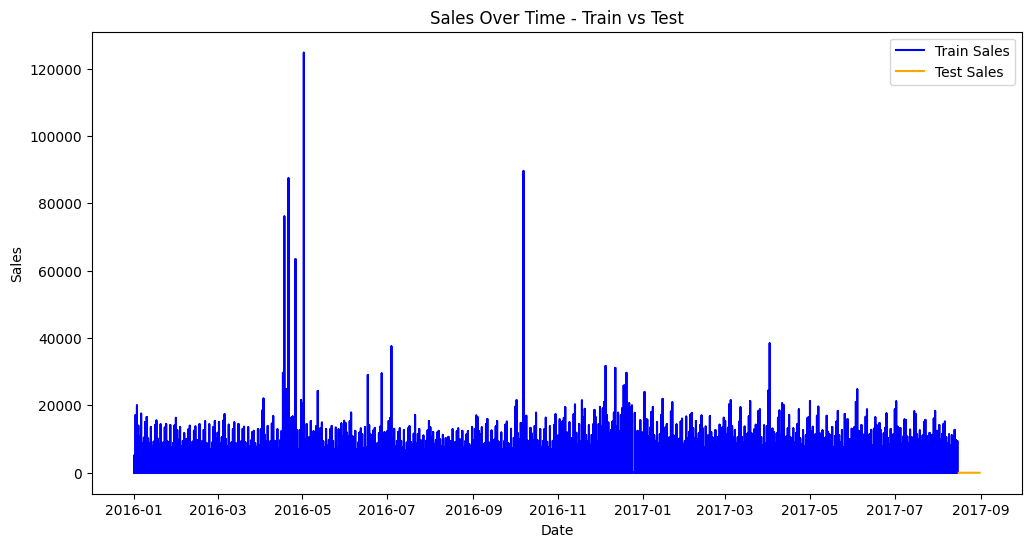

In [8]:
import matplotlib.pyplot as plt

# Combine year, month, and day into a datetime-like column for train and test
train['date'] = pd.to_datetime(train[['year', 'month', 'day']])
test['date'] = pd.to_datetime(test[['year', 'month', 'day']])

# Let's plot the sales over time for both train and test
plt.figure(figsize=(12, 6))

# Plot the training data sales
plt.plot(train['date'], train['sales'], label='Train Sales', color='blue')

# Plot the test data, since you may not have `sales` in the test, you can compare a feature or prediction
# Here we assume 'test' has a column called 'sales' or replace with predictions later.
plt.plot(test['date'], test['sales'], label='Test Sales', color='orange')

# Add titles and labels
plt.title('Sales Over Time - Train vs Test')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

# Show the plot
plt.show()


In [9]:
X = train.drop(columns=['sales'])
y = train['sales']

y_log = np.log1p(y)

X_train, X_val, y_train, y_val = train_test_split(X, y_log, test_size=0.2, random_state=42)

X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
X_val.columns = X_val.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
test.columns = test.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

X_train, test = X_train.align(test, join='left', axis=1, fill_value=0)
X_val, test = X_val.align(test, join='left', axis=1, fill_value=0)

train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)

# 2. Model Training (CatBoost, XGBoost, LightGBM)

## Defining model

In [ ]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
import numpy as np

train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)


catboost_params = {
    'iterations': 10000,
    'learning_rate': 0.15,
    'depth': 10,
    'random_seed': 42,
    'loss_function': 'RMSE',
    'verbose': 100,
    'early_stopping_rounds': 100,
    'task_type': 'GPU',
    'min_data_in_leaf': 30,
    'max_bin': 255,
}

# Initialize and train the CatBoost model
catboost_model = CatBoostRegressor(**catboost_params)
catboost_model.fit(train_pool, eval_set=val_pool, use_best_model=True, plot=True)

# Predict and evaluate
catboost_pred = catboost_model.predict(X_val)
catboost_rmse = np.sqrt(mean_squared_error(y_val, catboost_pred))
print(f"CatBoost RMSE: {catboost_rmse:.6f}")

# Feature importance
feature_importance = catboost_model.get_feature_importance()
feature_names = X_train.columns
sorted_idx = np.argsort(feature_importance)
print("\nTop 10 important features:")
for idx in sorted_idx[-10:]:
    print(f"{feature_names[idx]}: {feature_importance[idx]:.2f}")


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.3165105	test: 2.3130127	best: 2.3130127 (0)	total: 24.3ms	remaining: 4m 3s
100:	learn: 0.6345129	test: 0.6313120	best: 0.6313120 (100)	total: 1.56s	remaining: 2m 33s
200:	learn: 0.5389682	test: 0.5378474	best: 0.5378474 (200)	total: 3.01s	remaining: 2m 26s
300:	learn: 0.4975022	test: 0.4978773	best: 0.4978773 (300)	total: 4.49s	remaining: 2m 24s
400:	learn: 0.4716955	test: 0.4733025	best: 0.4733025 (400)	total: 5.95s	remaining: 2m 22s
500:	learn: 0.4537156	test: 0.4564620	best: 0.4564620 (500)	total: 7.46s	remaining: 2m 21s
600:	learn: 0.4418162	test: 0.4455673	best: 0.4455673 (600)	total: 9.22s	remaining: 2m 24s
700:	learn: 0.4322085	test: 0.4368661	best: 0.4368661 (700)	total: 11s	remaining: 2m 25s
800:	learn: 0.4239680	test: 0.4296331	best: 0.4296331 (800)	total: 12.6s	remaining: 2m 24s
900:	learn: 0.4176649	test: 0.4243659	best: 0.4243659 (900)	total: 14.4s	remaining: 2m 25s
1000:	learn: 0.4123951	test: 0.4201497	best: 0.4201497 (1000)	total: 16.1s	remaining: 2m 25s
110

In [11]:
# Drop any datetime columns if they exist (just in case they were added later)
X_train = X_train.select_dtypes(exclude=['datetime'])
X_val = X_val.select_dtypes(exclude=['datetime'])
test = test.select_dtypes(exclude=['datetime'])


In [12]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler

# Preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dval = xgb.DMatrix(X_val_scaled, label=y_val)

# Set XGBoost parameters
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'tree_method':'hist','device':'cuda',
    'learning_rate': 0.05,  # Reduced for potentially better generalization
    'max_depth': 9,
    'min_child_weight': 1.5,
    'subsample': 0.6,
    'gamma': 0.2,
    'reg_alpha': 0.9,
    'reg_lambda': 1.3,
    'random_state': 42
}

# Train the XGBoost model
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=20000,  # Increased from 15000
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=200,
    verbose_eval=100
)

# Predict and evaluate
xgb_pred = xgb_model.predict(dval)
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))
print(f"XGBoost RMSE: {xgb_rmse:.6f}")

# Feature importance
feature_importance = xgb_model.get_score(importance_type='gain')
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 important features:")
for feature, importance in sorted_importance[:10]:
    print(f"{feature}: {importance:.2f}")


[0]	train-rmse:2.48165	validation-rmse:2.47762
[100]	train-rmse:0.69911	validation-rmse:0.69774
[200]	train-rmse:0.53206	validation-rmse:0.53492
[300]	train-rmse:0.48085	validation-rmse:0.48638
[400]	train-rmse:0.45426	validation-rmse:0.46163
[500]	train-rmse:0.43418	validation-rmse:0.44385
[600]	train-rmse:0.42048	validation-rmse:0.43233
[700]	train-rmse:0.41079	validation-rmse:0.42478
[800]	train-rmse:0.40284	validation-rmse:0.41884
[900]	train-rmse:0.39625	validation-rmse:0.41418
[1000]	train-rmse:0.39114	validation-rmse:0.41082
[1100]	train-rmse:0.38636	validation-rmse:0.40779
[1200]	train-rmse:0.38234	validation-rmse:0.40539
[1300]	train-rmse:0.37873	validation-rmse:0.40341
[1400]	train-rmse:0.37522	validation-rmse:0.40144
[1500]	train-rmse:0.37220	validation-rmse:0.39993
[1600]	train-rmse:0.36966	validation-rmse:0.39874
[1700]	train-rmse:0.36712	validation-rmse:0.39750
[1800]	train-rmse:0.36488	validation-rmse:0.39653
[1900]	train-rmse:0.36277	validation-rmse:0.39554
[2000]	train

In [13]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Ensure the GPU is enabled in Kaggle
print(lgb.__version__)  # Check LightGBM version to ensure it supports GPU

# Create Dataset for LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Set LightGBM parameters for GPU usage
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',   # Gradient Boosting Decision Trees
    'device': 'gpu',           # Enable GPU
    'gpu_use_dp': False,       # Use single precision for GPU
    'num_leaves': 100,         # Increased from 31 (GPU handles deeper trees better)
    'max_depth': -1,           # -1 means no limit
    'learning_rate': 0.05,     # Reduced for potentially better generalization
    'feature_fraction': 0.8,   # Subsampling of features
    'bagging_fraction': 0.8,   # Subsampling of data
    'bagging_freq': 5,         # Frequency of bagging
    'verbose': -1,
    'num_threads': -1,         # Use all available cores for multi-threading
    'lambda_l1': 0.1,          # L1 regularization
    'lambda_l2': 0.1,          # L2 regularization
    'min_data_in_leaf': 20,    # Minimum data in leaf nodes
    'random_state': 42         # Ensure reproducibility
}

# Train the LightGBM model
lgb_model = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=20000,  # Increased from 10000 to allow more boosting rounds
    valid_sets=[train_data, val_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=200, verbose=True),
        lgb.log_evaluation(period=100)  # Log every 100 rounds
    ]
)

# Predict and evaluate
lgb_pred = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
lgb_rmse = np.sqrt(mean_squared_error(y_val, lgb_pred))
print(f"LightGBM RMSE: {lgb_rmse:.6f}")

# Feature importance (using gain importance type)
feature_importance = lgb_model.feature_importance(importance_type='gain')
feature_names = lgb_model.feature_name()
sorted_idx = np.argsort(feature_importance)

# Print top 10 important features
print("\nTop 10 important features:")
for idx in sorted_idx[-10:]:
    print(f"{feature_names[idx]}: {feature_importance[idx]}")


4.2.0


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.58494	valid_1's rmse: 0.583733
[200]	training's rmse: 0.508044	valid_1's rmse: 0.508794
[300]	training's rmse: 0.47775	valid_1's rmse: 0.479579
[400]	training's rmse: 0.458873	valid_1's rmse: 0.461829
[500]	training's rmse: 0.445486	valid_1's rmse: 0.449549
[600]	training's rmse: 0.434325	valid_1's rmse: 0.439388
[700]	training's rmse: 0.425871	valid_1's rmse: 0.431956
[800]	training's rmse: 0.418666	valid_1's rmse: 0.425764
[900]	training's rmse: 0.412394	valid_1's rmse: 0.420534
[1000]	training's rmse: 0.407207	valid_1's rmse: 0.416325
[1100]	training's rmse: 0.402464	valid_1's rmse: 0.412465
[1200]	training's rmse: 0.398611	valid_1's rmse: 0.409474
[1300]	training's rmse: 0.395135	valid_1's rmse: 0.406738
[1400]	training's rmse: 0.391802	valid_1's rmse: 0.404274
[1500]	training's rmse: 0.389087	valid_1's rmse: 0.402274
[1600]	training's rmse: 0.386422	valid_1's rmse: 0.400484
[1700]	training's rms

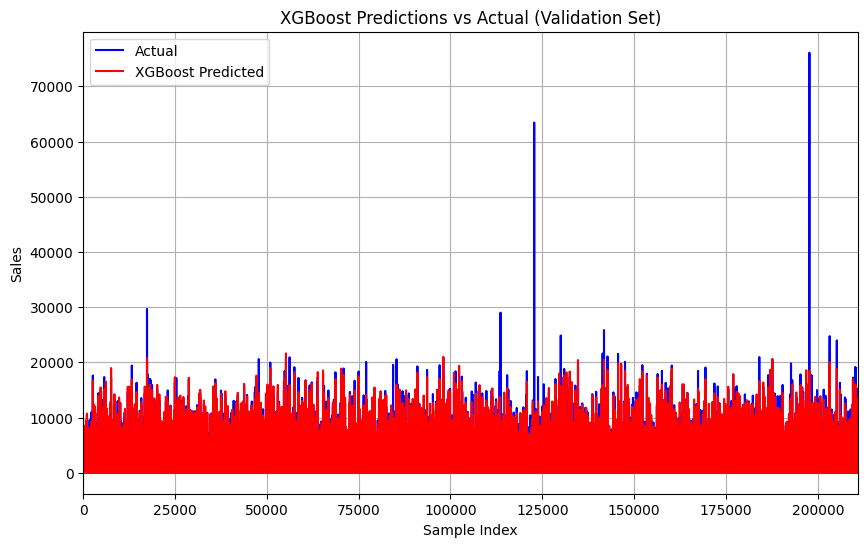

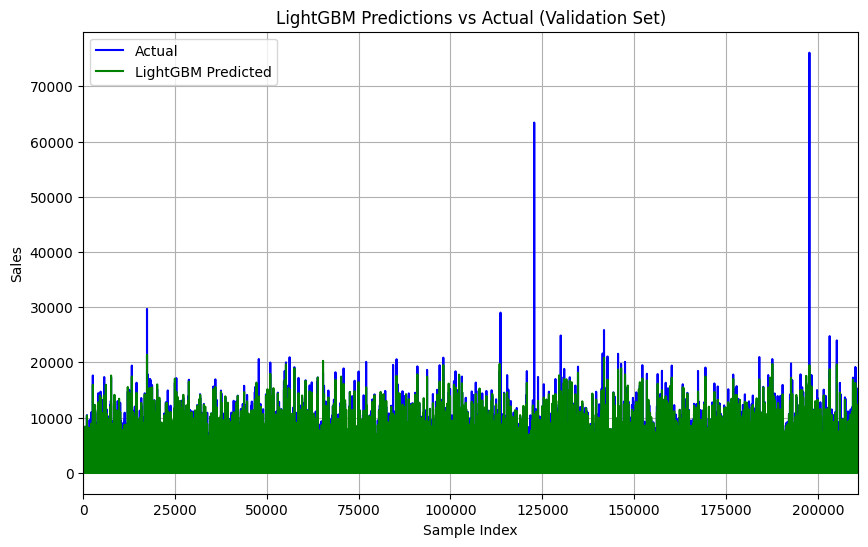

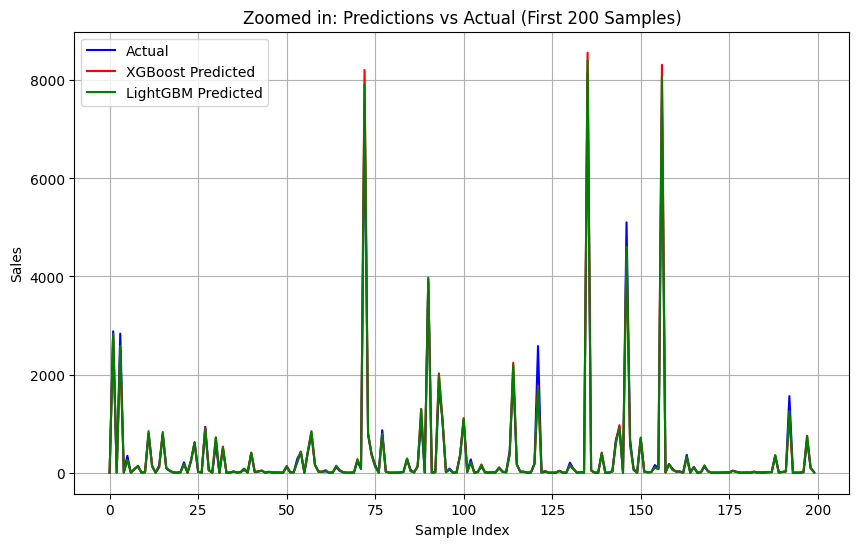

In [15]:
import matplotlib.pyplot as plt

# Inverse log transformation (since y was log-transformed earlier)
y_val_inv = np.expm1(y_val)
xgb_pred_inv = np.expm1(xgb_pred)
lgb_pred_inv = np.expm1(lgb_pred)

# Plot XGBoost predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_val_inv)), y_val_inv, label='Actual', color='blue')
plt.plot(range(len(xgb_pred_inv)), xgb_pred_inv, label='XGBoost Predicted', color='red')
plt.title('XGBoost Predictions vs Actual (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.xlim(0, len(y_val_inv))  # Zoom into the validation set
plt.show()

# Plot LightGBM predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_val_inv)), y_val_inv, label='Actual', color='blue')
plt.plot(range(len(lgb_pred_inv)), lgb_pred_inv, label='LightGBM Predicted', color='green')
plt.title('LightGBM Predictions vs Actual (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.xlim(0, len(y_val_inv))  # Zoom into the validation set
plt.show()

# Zoom in further if needed for better visualization
plt.figure(figsize=(10, 6))
plt.plot(range(200), y_val_inv[:200], label='Actual', color='blue')
plt.plot(range(200), xgb_pred_inv[:200], label='XGBoost Predicted', color='red')
plt.plot(range(200), lgb_pred_inv[:200], label='LightGBM Predicted', color='green')
plt.title('Zoomed in: Predictions vs Actual (First 200 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


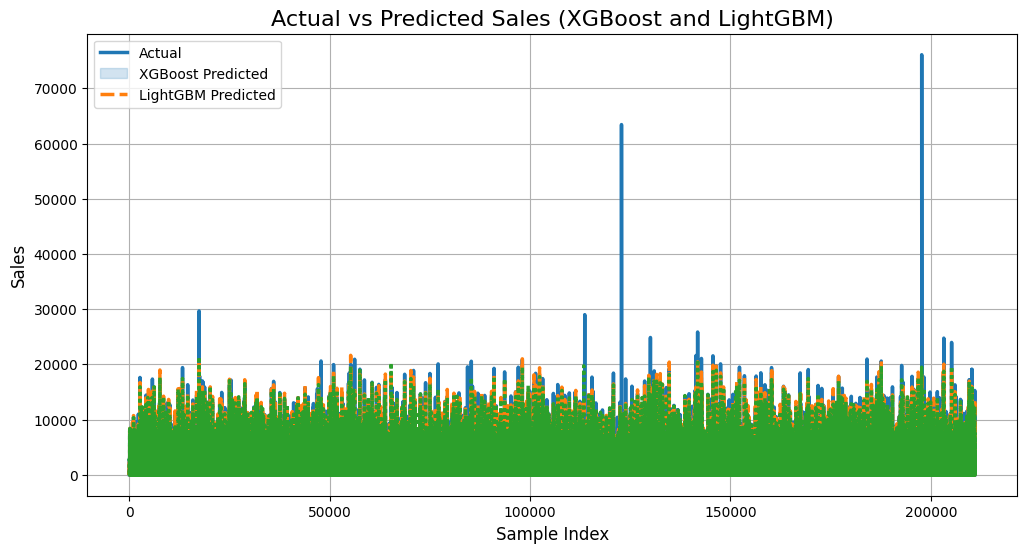

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


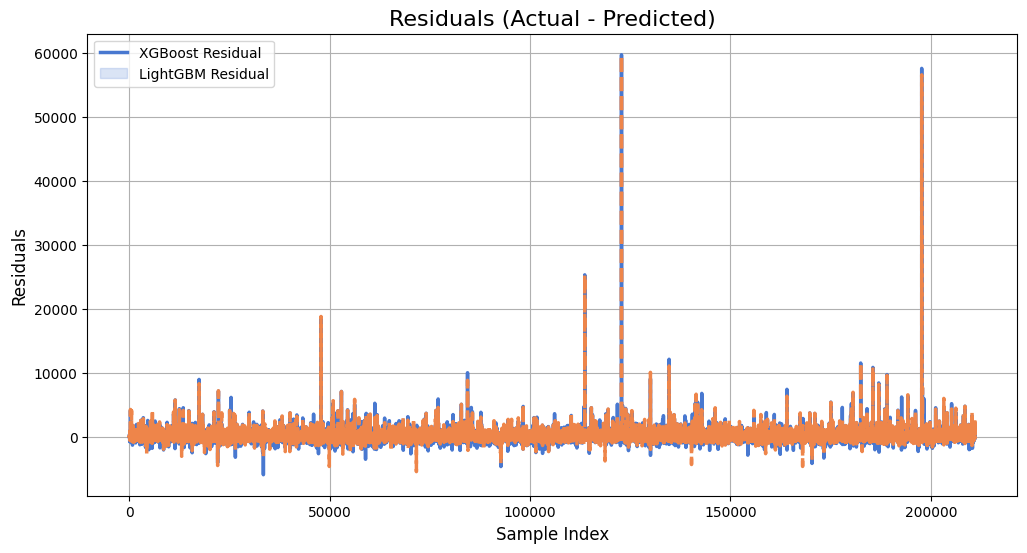

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


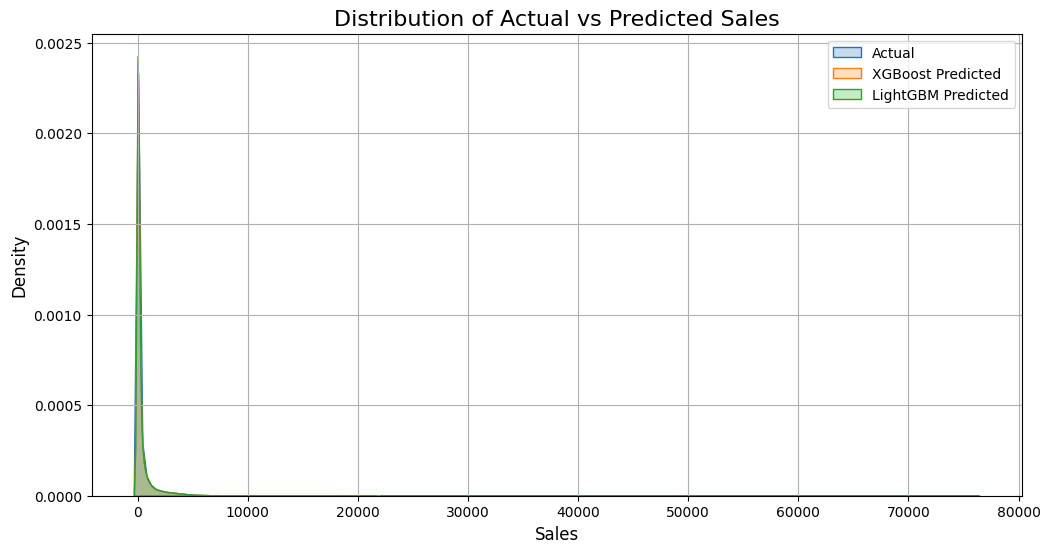

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert predictions and actual values to a DataFrame for better plotting
plot_df = pd.DataFrame({
    'Actual': y_val_inv,
    'XGBoost Predicted': xgb_pred_inv,
    'LightGBM Predicted': lgb_pred_inv
}).reset_index(drop=True)

# Lineplot with Seaborn (for actual vs predicted values)
plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_df, palette="tab10", linewidth=2.5)
plt.title('Actual vs Predicted Sales (XGBoost and LightGBM)', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.grid(True)
plt.legend(['Actual', 'XGBoost Predicted', 'LightGBM Predicted'])
plt.show()

# Residual Plot (actual - predicted)
plot_df['XGBoost Residual'] = plot_df['Actual'] - plot_df['XGBoost Predicted']
plot_df['LightGBM Residual'] = plot_df['Actual'] - plot_df['LightGBM Predicted']

plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_df[['XGBoost Residual', 'LightGBM Residual']], palette="muted", linewidth=2.5)
plt.title('Residuals (Actual - Predicted)', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.grid(True)
plt.legend(['XGBoost Residual', 'LightGBM Residual'])
plt.show()

# KDE Plot (Kernel Density Estimate) for the distribution of actual vs predicted
plt.figure(figsize=(12, 6))
sns.kdeplot(plot_df['Actual'], label='Actual', fill=True)
sns.kdeplot(plot_df['XGBoost Predicted'], label='XGBoost Predicted', fill=True)
sns.kdeplot(plot_df['LightGBM Predicted'], label='LightGBM Predicted', fill=True)
plt.title('Distribution of Actual vs Predicted Sales', fontsize=16)
plt.xlabel('Sales', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


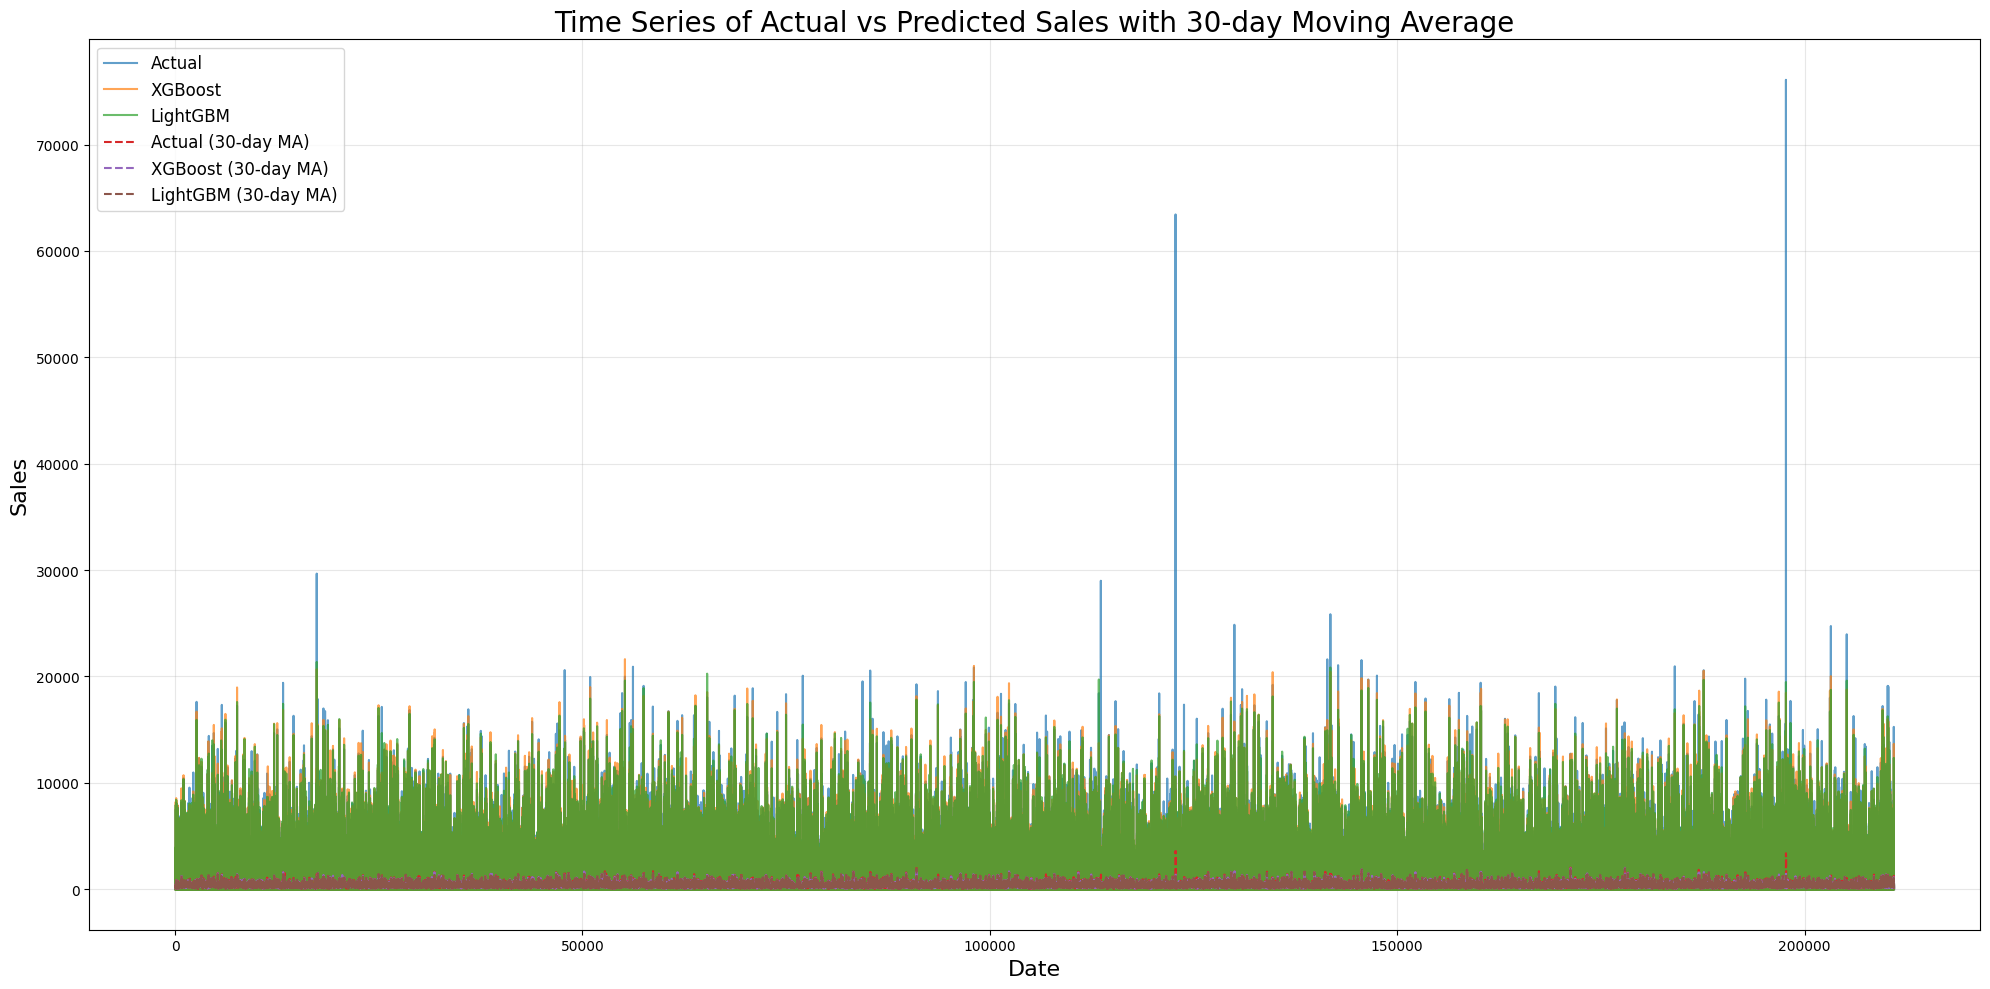

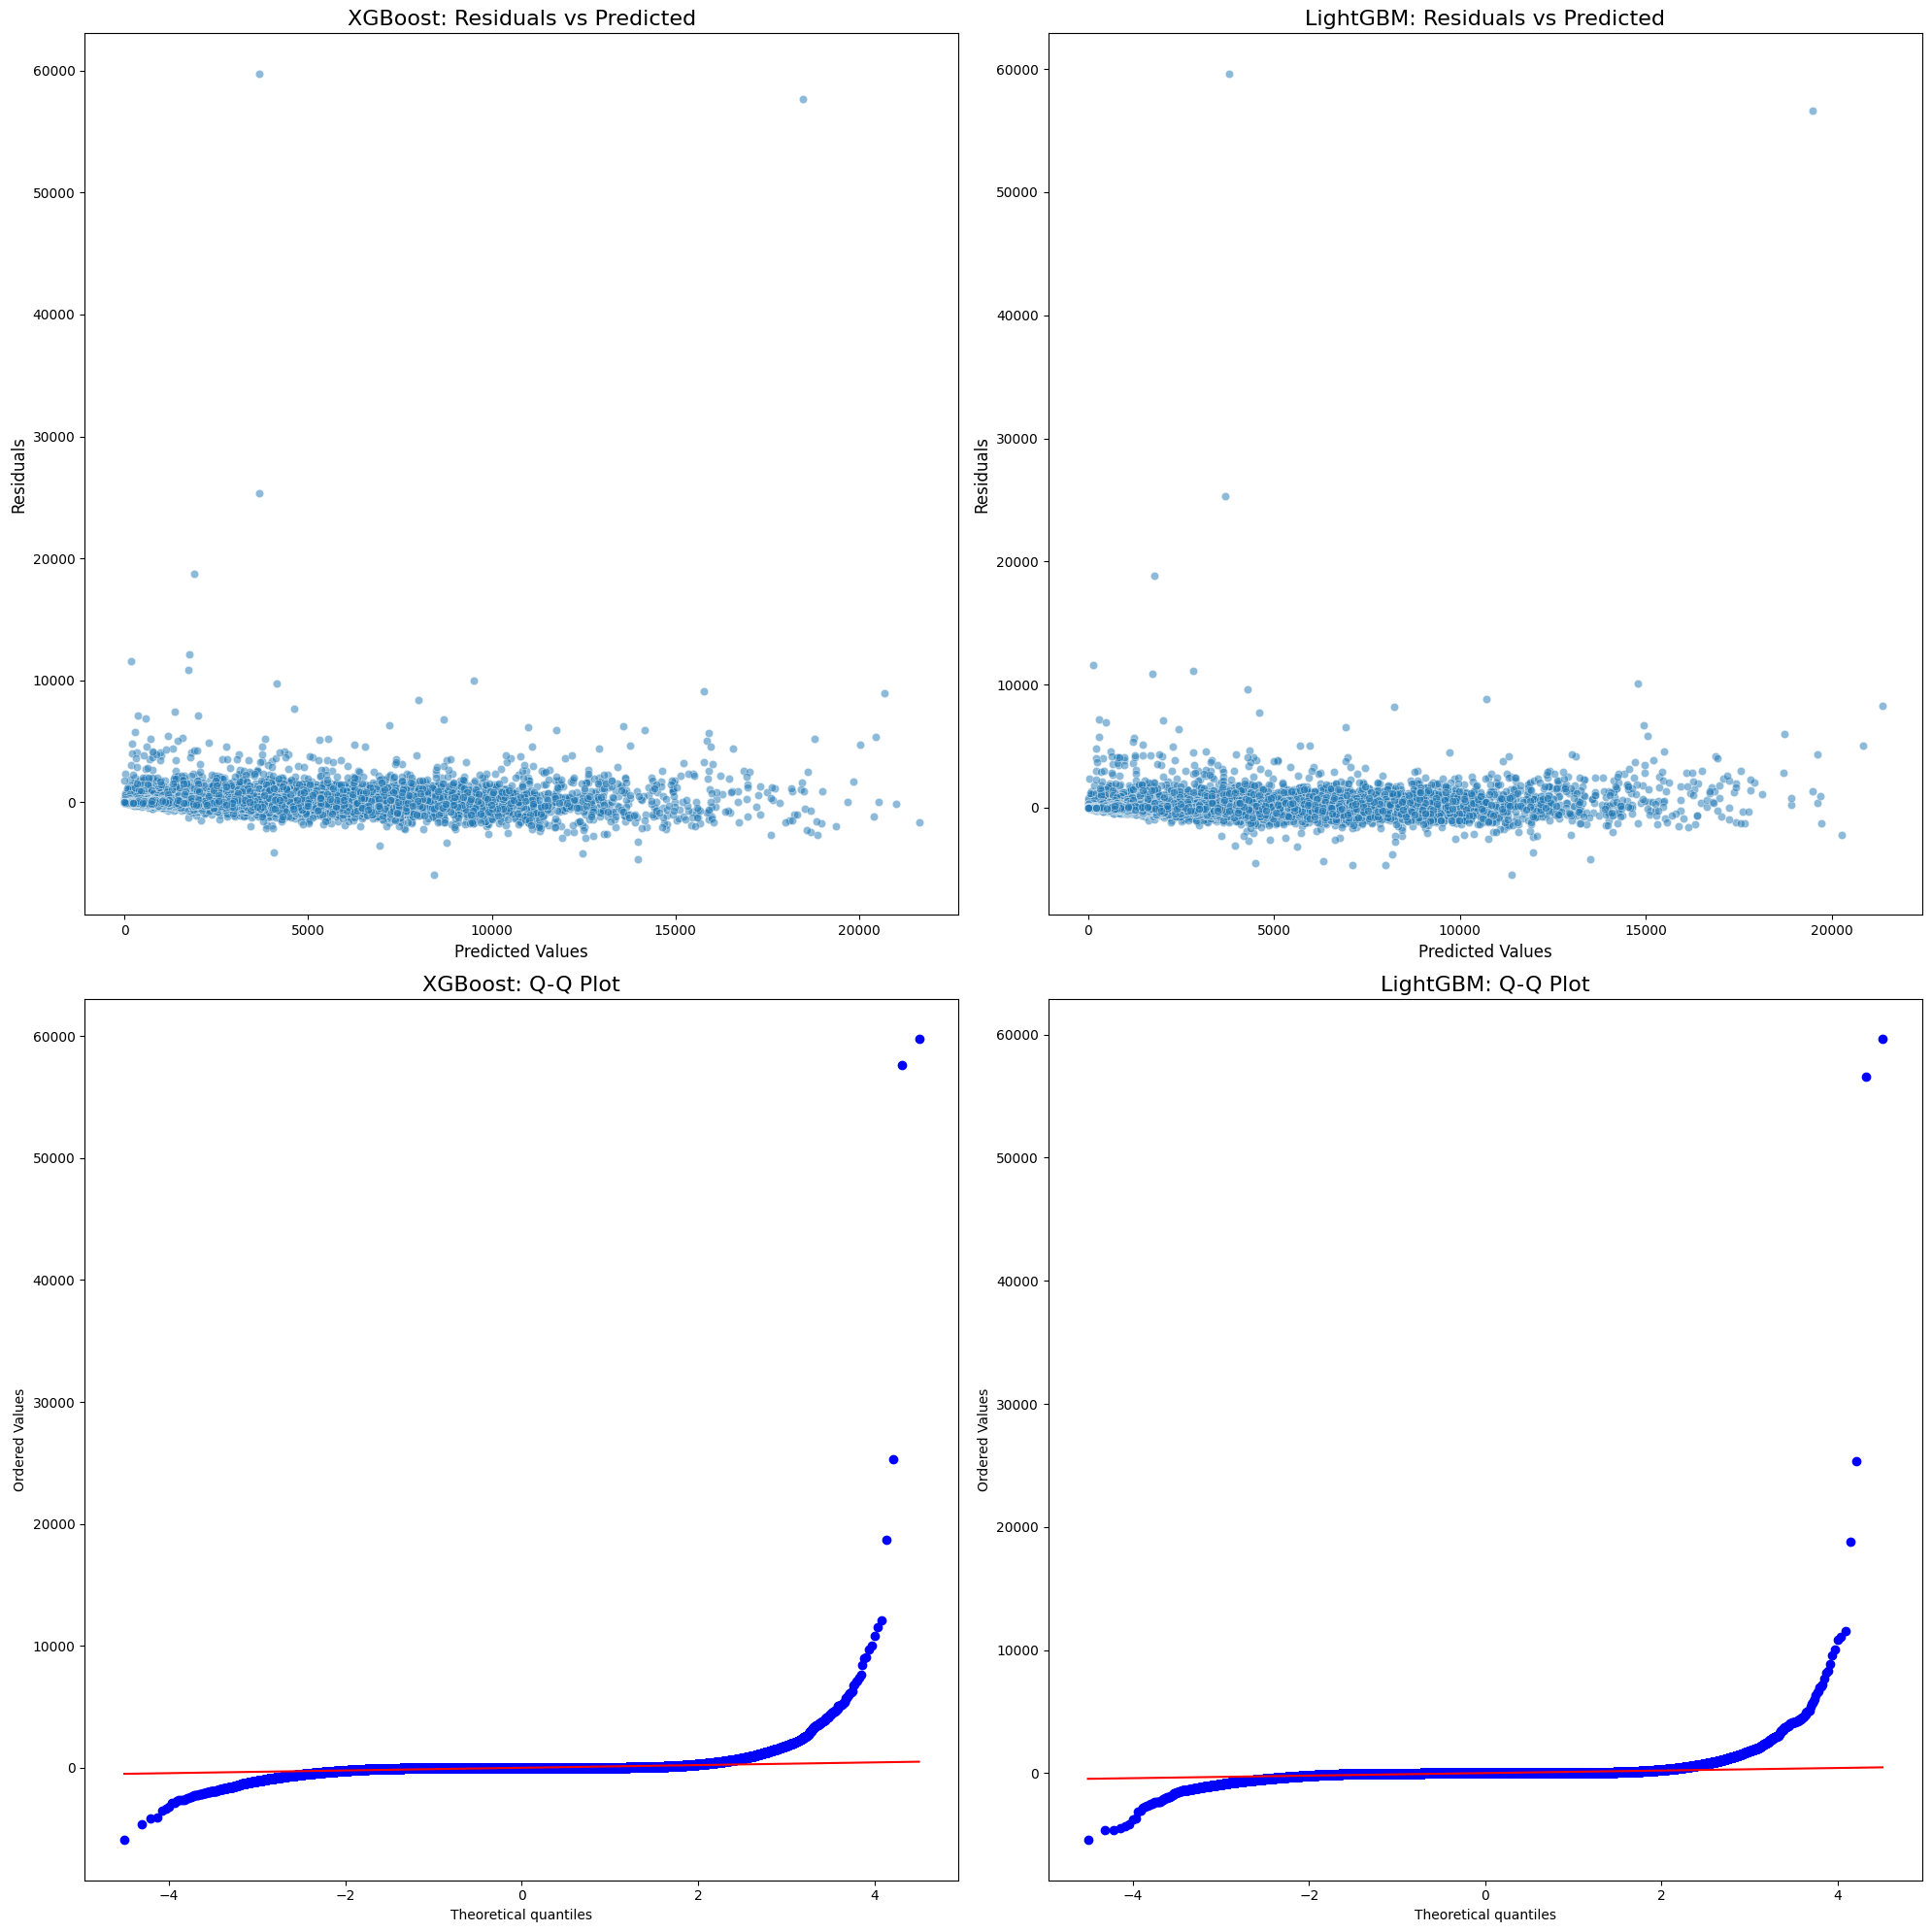

Time series and residual analysis plots should now be displayed.


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Assuming plot_df is already created and contains the necessary data

def plot_time_series():
    plt.figure(figsize=(20, 10))
    plt.plot(plot_df.index, plot_df['Actual'], label='Actual', alpha=0.7)
    plt.plot(plot_df.index, plot_df['XGBoost Predicted'], label='XGBoost', alpha=0.7)
    plt.plot(plot_df.index, plot_df['LightGBM Predicted'], label='LightGBM', alpha=0.7)

    window = 30  # Adjust as needed
    plt.plot(plot_df.index, plot_df['Actual'].rolling(window=window).mean(), label='Actual (30-day MA)', linestyle='--')
    plt.plot(plot_df.index, plot_df['XGBoost Predicted'].rolling(window=window).mean(), label='XGBoost (30-day MA)', linestyle='--')
    plt.plot(plot_df.index, plot_df['LightGBM Predicted'].rolling(window=window).mean(), label='LightGBM (30-day MA)', linestyle='--')

    plt.title('Time Series of Actual vs Predicted Sales with 30-day Moving Average', fontsize=20)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Sales', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_residual_analysis():
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))

    sns.scatterplot(x=plot_df['XGBoost Predicted'], y=plot_df['XGBoost Residual'], ax=axes[0, 0], alpha=0.5)
    axes[0, 0].set_title('XGBoost: Residuals vs Predicted', fontsize=16)
    axes[0, 0].set_xlabel('Predicted Values', fontsize=12)
    axes[0, 0].set_ylabel('Residuals', fontsize=12)

    sns.scatterplot(x=plot_df['LightGBM Predicted'], y=plot_df['LightGBM Residual'], ax=axes[0, 1], alpha=0.5)
    axes[0, 1].set_title('LightGBM: Residuals vs Predicted', fontsize=16)
    axes[0, 1].set_xlabel('Predicted Values', fontsize=12)
    axes[0, 1].set_ylabel('Residuals', fontsize=12)

    stats.probplot(plot_df['XGBoost Residual'].dropna(), dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title("XGBoost: Q-Q Plot", fontsize=16)

    stats.probplot(plot_df['LightGBM Residual'].dropna(), dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title("LightGBM: Q-Q Plot", fontsize=16)

    plt.tight_layout()
    plt.show()

# Execute plots
plot_time_series()
plot_residual_analysis()

print("Time series and residual analysis plots should now be displayed.")

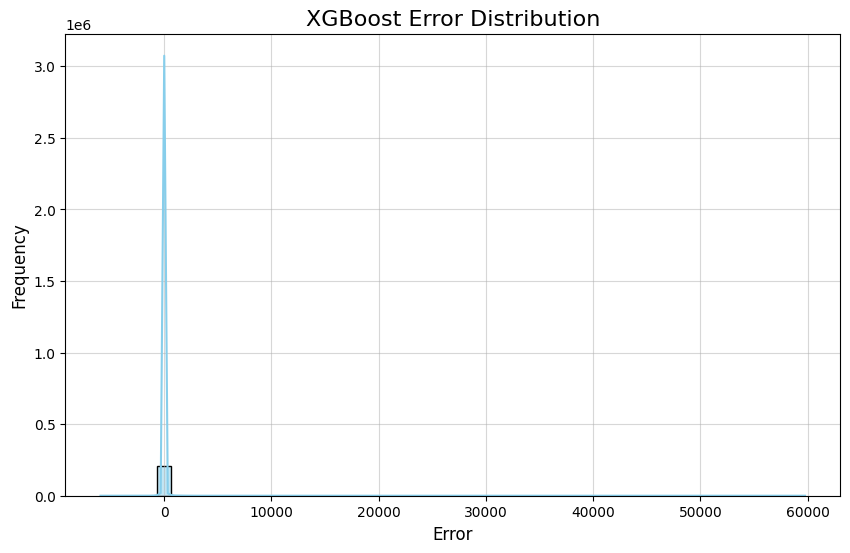

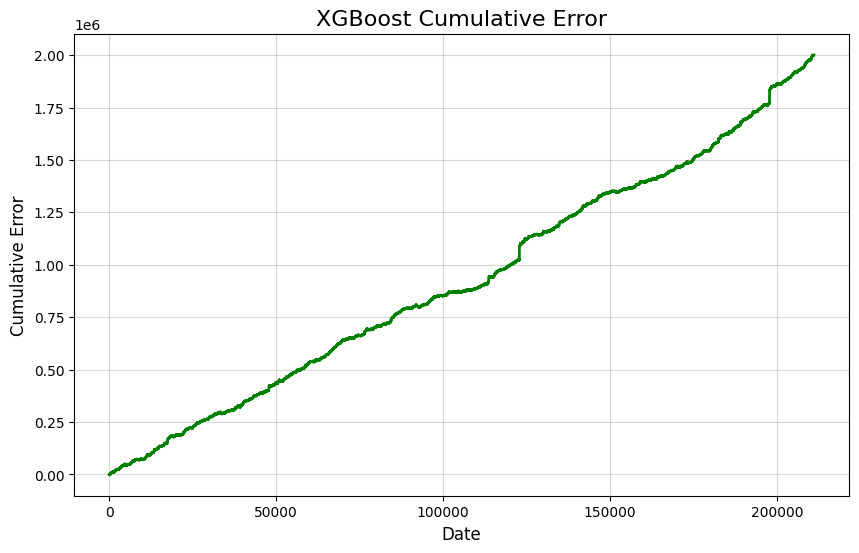

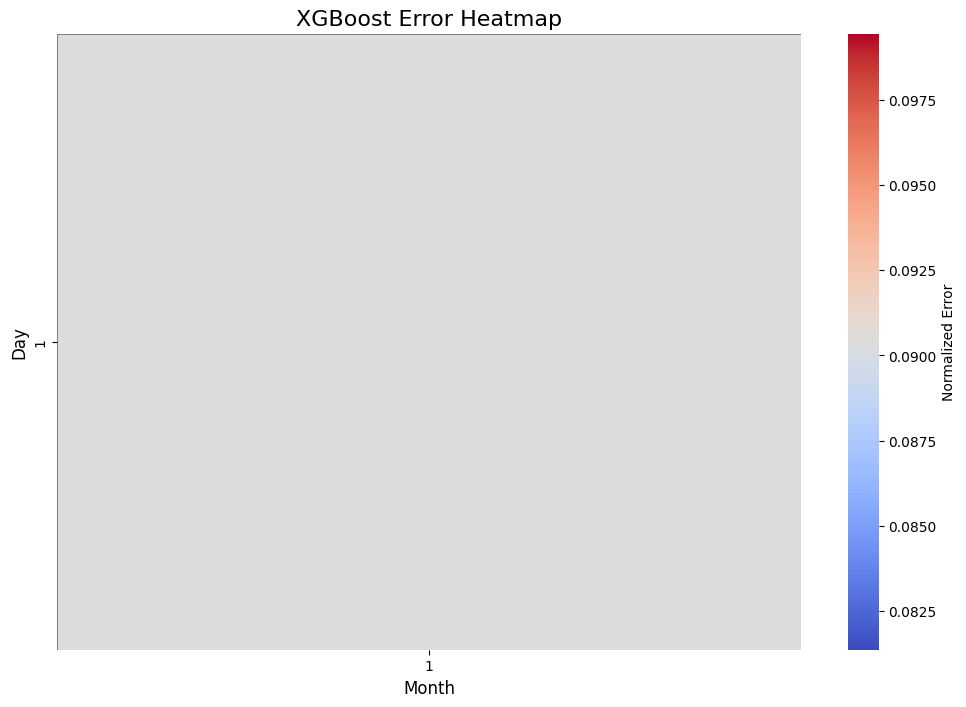

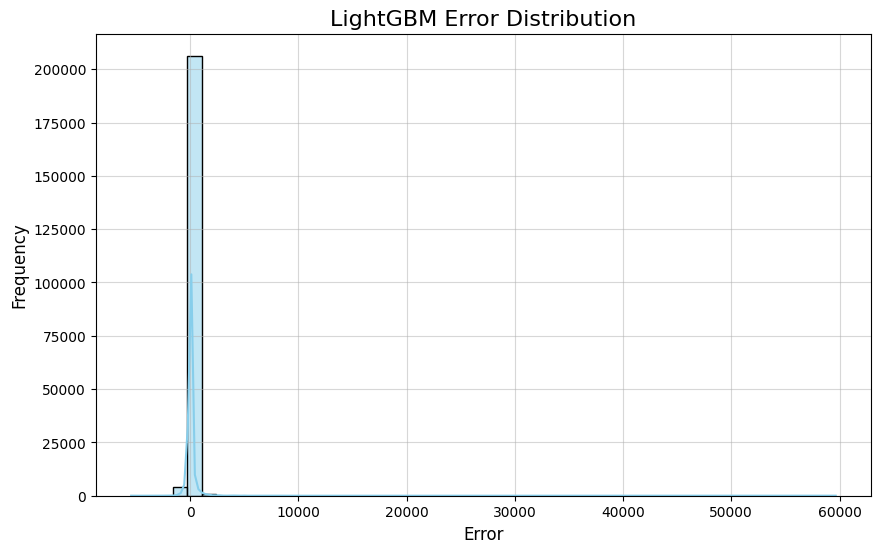

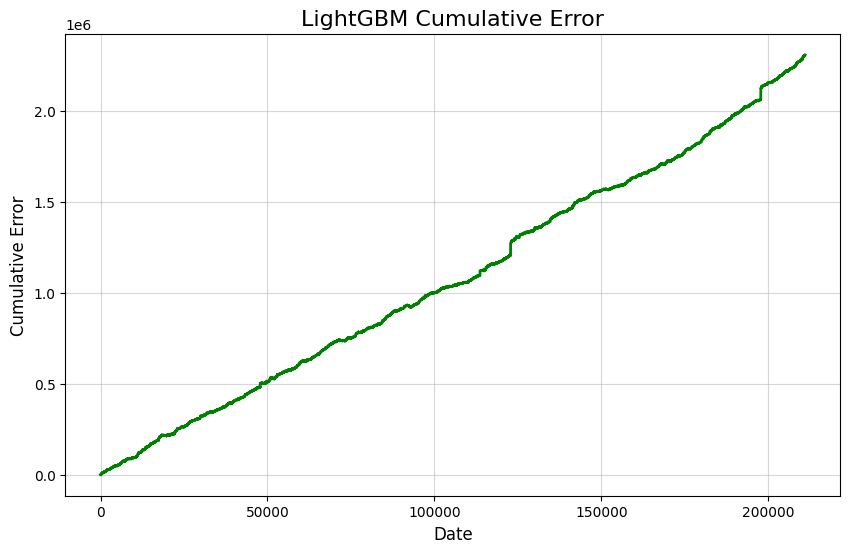

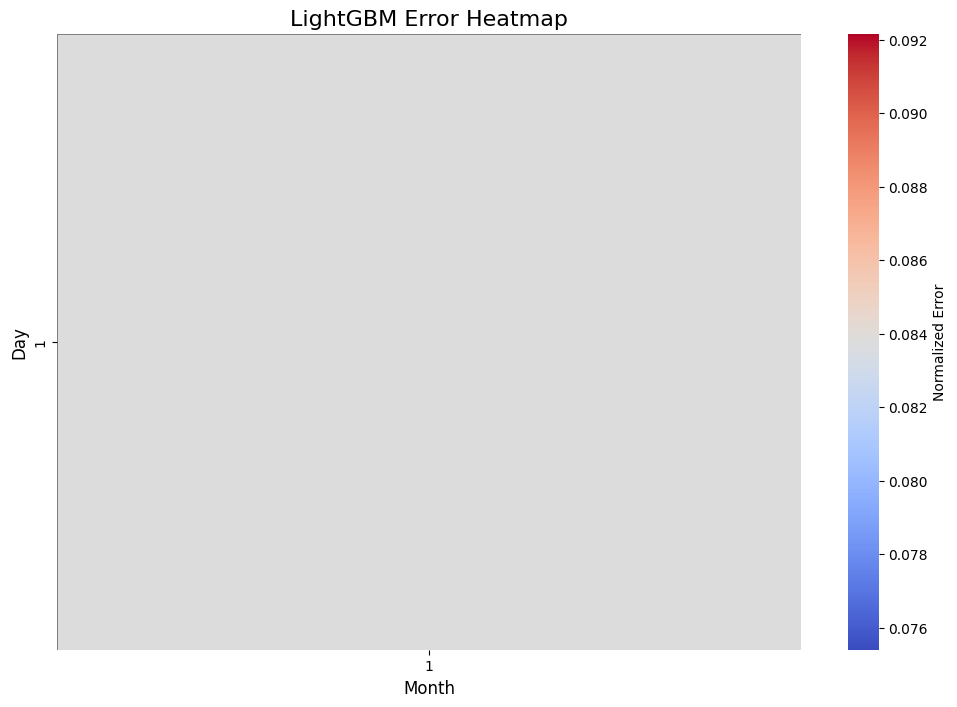

Updated error plots should now be displayed.


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Adding seaborn for better visualization

def plot_error_histogram(data, model_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[f'{model_name} Residual'].dropna(), bins=50, kde=True, color='skyblue', edgecolor='black')
    plt.title(f'{model_name} Error Distribution', fontsize=16)
    plt.xlabel('Error', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.5)
    plt.show()

def plot_cumulative_error(data, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data[f'{model_name} Residual'].cumsum(), color='green', linewidth=2)
    plt.title(f'{model_name} Cumulative Error', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Error', fontsize=12)
    plt.grid(True, alpha=0.5)
    plt.show()

def plot_error_heatmap(data, model_name):
    # Prepare data
    data = data.copy()

    # Ensure index is a DatetimeIndex
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)

    data['Month'] = data.index.month
    data['Day'] = data.index.day
    
    # Normalize the residuals to a scale between 0 and 1 for better heatmap contrast
    data[f'{model_name} Residual Normalized'] = (data[f'{model_name} Residual'] - data[f'{model_name} Residual'].min()) / \
                                               (data[f'{model_name} Residual'].max() - data[f'{model_name} Residual'].min())
    
    # Create pivot table for heatmap
    pivot = data.pivot_table(index='Day', columns='Month', values=f'{model_name} Residual Normalized', aggfunc='mean')
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot, cmap='coolwarm', annot=False, cbar_kws={'label': 'Normalized Error'}, linewidths=0.5, linecolor='gray')
    plt.title(f'{model_name} Error Heatmap', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Day', fontsize=12)
    plt.show()

# Execute plots for XGBoost
plot_error_histogram(plot_df, 'XGBoost')
plot_cumulative_error(plot_df, 'XGBoost')
plot_error_heatmap(plot_df, 'XGBoost')

# Execute plots for LightGBM
plot_error_histogram(plot_df, 'LightGBM')
plot_cumulative_error(plot_df, 'LightGBM')
plot_error_heatmap(plot_df, 'LightGBM')

print("Updated error plots should now be displayed.")


In [45]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Combine training and validation datasets
X_full_train = np.vstack((X_train, X_val))  # Stack features
y_full_train = np.hstack((y_train, y_val))  # Stack labels

# Create new LightGBM Dataset for the full training set
full_train_data = lgb.Dataset(X_full_train, label=y_full_train)

# Set LightGBM parameters for CPU usage (removing GPU settings)
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',   # Gradient Boosting Decision Trees
    'device': 'gpu',           # Enable GPU
    'gpu_use_dp': True,       # Use single precision for GPU
    'num_leaves': 100,         # Increased from 31 (GPU handles deeper trees better)
    'max_depth': -1,           # -1 means no limit
    'learning_rate': 0.07,     # Reduced for potentially better generalization
    'feature_fraction': 0.8,   # Subsampling of features
    'bagging_fraction': 0.8,   # Subsampling of data
    'bagging_freq': 5,         # Frequency of bagging
    'verbose':-1,
    'num_threads': -1,         # Use all available cores for multi-threading
    'lambda_l1': 0.1,          # L1 regularization
    'lambda_l2': 0.1,          # L2 regularization
    'min_data_in_leaf': 20,    # Minimum data in leaf nodes
    'random_state': 42         # Ensure reproducibility
}

# Train the LightGBM model on the full training dataset
lgb_model_full = lgb.train(
    lgb_params,
    full_train_data,
    num_boost_round=4000,  # Use the best iteration from previous training
    callbacks=[
        lgb.log_evaluation(period=100)  # Log every 100 rounds
    ]
)

# Optionally evaluate the model on the training data
y_train_pred = lgb_model_full.predict(X_full_train)
rmse = np.sqrt(mean_squared_error(y_full_train, y_train_pred))
print(f'Training RMSE: {rmse}')

Training RMSE: 0.34437695778898936


# 3. Model Prediction

In [46]:
test_predictions_log = lgb_model_full.predict(test)

test['sales'] = np.expm1(test_predictions_log)
test['sales'] = np.where(test['sales'] < 0, 0, test['sales'])  

In [47]:
test.head()

,id,store_nbr,onpromotion,holiday,year,month,day,weekday,family_BABY_CARE,family_BEAUTY,...,family_MEATS,family_PERSONAL_CARE,family_PET_SUPPLIES,family_PLAYERS_AND_ELECTRONICS,family_POULTRY,family_PREPARED_FOODS,family_PRODUCE,family_SCHOOL_AND_OFFICE_SUPPLIES,family_SEAFOOD,sales
0,3000888,1,0,False,2017,8,16,2,False,False,...,False,False,False,False,False,False,False,False,False,4.368066
1,3000889,1,0,False,2017,8,16,2,True,False,...,False,False,False,False,False,False,False,False,False,0.000000
2,3000890,1,2,False,2017,8,16,2,False,True,...,False,False,False,False,False,False,False,False,False,6.297571
3,3000891,1,20,False,2017,8,16,2,False,False,...,False,False,False,False,False,False,False,False,False,2325.389931
4,3000892,1,0,False,2017,8,16,2,False,False,...,False,False,False,False,False,False,False,False,False,0.138679


# 4. Submission

In [48]:

submission = test[['id', 'sales']]
submission

,id,sales
0,3000888,4.368066
1,3000889,0.000000
2,3000890,6.297571
3,3000891,2325.389931
4,3000892,0.138679
...,...,...
28507,3029395,347.642859
28508,3029396,86.339679
28509,3029397,1207.336467
28510,3029398,101.282370


In [49]:
submission.to_csv('submission.csv', index=False)